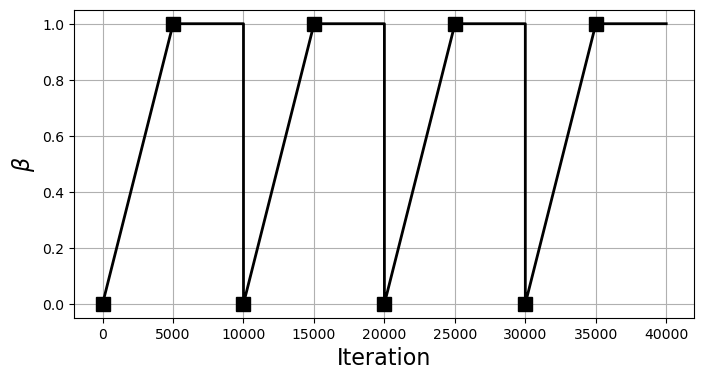

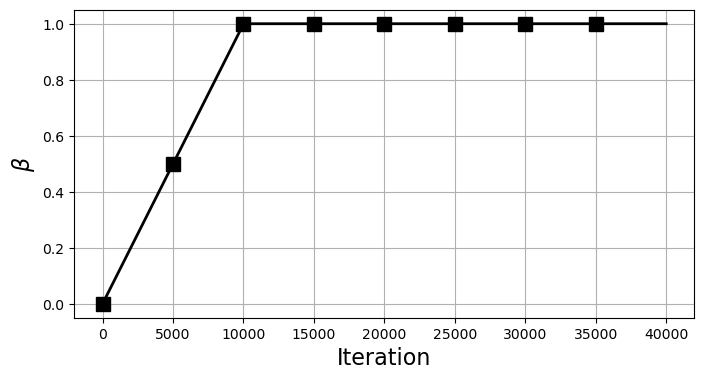

In [1]:
import matplotlib.pyplot as plt
import numpy as np

class kl_annealing():
    def __init__(self, _type, cycle=1, ratio=1):
        self.cur_iter = 0

        self.type = _type
        self.cycle = cycle
        self.ratio = ratio

        self.total_iter = 40000
        
        self.beta_list = np.ones(self.total_iter)

        if(self.type == 'Cyclical'):
            self.frange_cycle_linear(self.total_iter, n_cycle=self.cycle, ratio=self.ratio)
        elif(self.type == 'Monotonic'):
            self.frange_cycle_linear(self.total_iter, n_cycle=1, ratio=0.25)
        elif(self.type == 'None'):
            self.beta_list = np.zeros(self.total_iter)
            
    def update(self):
        self.cur_iter += 1
    
    def get_beta(self):
        return self.beta_list[self.cur_iter]


    def frange_cycle_linear(self, n_iter, start=0.0, stop=1.0,  n_cycle=1, ratio=1):
        period = n_iter / n_cycle
        step = (stop - start) / (period * ratio)

        for c in range(n_cycle):
            v, i = start, 0
            while v <= stop and (int(i + c * period) < n_iter):
                self.beta_list[int(i + c * period)] = v
                v += step
                i += 1
                
                
def plot_kl_annealing(num_epoch, beta_list):
    import matplotlib.pyplot as plt
    fig=plt.figure(figsize=(8, 4.0))
    stride = max( int(num_epoch / 8), 1)
    plt.plot(beta_list, marker= 's', color='k', markevery=stride, lw=2,  mec='k', mew=1 , markersize=10)
    plt.grid(True)
    plt.xlabel('Iteration', fontsize=16)
    plt.ylabel("$\\beta$", fontsize=16)
    plt.show()

KL = kl_annealing('Cyclical', 4, 0.5)
plot_kl_annealing(num_epoch=KL.total_iter, beta_list=KL.beta_list)

KL = kl_annealing('Monotonic')
plot_kl_annealing(num_epoch=KL.total_iter, beta_list=KL.beta_list)

In [10]:
import os
from glob import glob
import torch
from torch import stack
from torch.utils.data import Dataset as torchData

from torchvision.datasets.folder import default_loader as imgloader
from torch import stack
def get_key(fp):
    filename = fp.split('\\')[-1]
    filename = filename.split('.')[0].replace('frame', '')
#     print(f'filename = {filename}')
    filename = filename.replace('train_img\\', '')  # 移除 "train_img" 字串
    return int(filename)

class Dataset_Dance(torchData):
    def __init__(self, root, transform, mode='train', video_len=7, partial=1.0):
        super().__init__()
        assert mode in ['train', 'val'], "There is no such mode !!!"
        if mode == 'train':
            self.img_folder     = sorted(glob(os.path.join(root, 'LAB4_Dataset\\train\\train_img\\*.png')), key=get_key)
            self.prefix = 'train'
        elif mode == 'val':
            self.img_folder     = sorted(glob(os.path.join(root, 'LAB4_Dataset\\val\\val_img\\*.png')), key=get_key)
            self.prefix = 'val'
        else:
            raise NotImplementedError
        
        self.transform = transform
        self.partial = partial
        self.video_len = video_len

    def __len__(self):
        return int(len(self.img_folder) * self.partial) // self.video_len

    def __getitem__(self, index):
        path = self.img_folder[index]
        
        imgs = []
        labels = []
        for i in range(self.video_len):
            label_list = self.img_folder[(index*self.video_len)+i].split('/')
            label_list[-2] = self.prefix + '_label'
            
            img_name    = self.img_folder[(index*self.video_len)+i]
            label_name = '/'.join(label_list)

            imgs.append(self.transform(imgloader(img_name)))
            labels.append(self.transform(imgloader(label_name)))
        return stack(imgs), stack(labels)

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader

def train_dataloader():
    transform = transforms.Compose([
        transforms.Resize((32, 64)),
        transforms.ToTensor()
    ])

    dataset = Dataset_Dance(root=".", transform=transform, mode='train', video_len=16, \
                                            partial=0.4)

    train_loader = DataLoader(dataset,
                              batch_size=2,
                              num_workers=4,
                              drop_last=True,
                              shuffle=False)  
    return train_loader

In [ ]:
train_loader = train_dataloader()
len(train_loader) # 23410 / 16 = 1463

In [11]:
from torchvision import transforms
from torch.utils.data import DataLoader

def val_dataloader():
    transform = transforms.Compose([
        transforms.Resize((32, 64)),
        transforms.ToTensor()
    ])
    dataset = Dataset_Dance(root=".", transform=transform, mode='val', video_len=630, partial=1.0)  
    val_loader = DataLoader(dataset,
                              batch_size=1,
                              num_workers=4,
                              drop_last=True,
                              shuffle=False)  
    return val_loader

In [12]:
val_loader = val_dataloader()
len(val_loader) # 1

1

In [ ]:
%pwd

In [ ]:
%run Trainer.py --DR LAB4_Dataset --save_root checkpoint --fast_train